In [1]:
import os, re, time, pickle, collections, importlib, datetime, torch
import pandas as pd, numpy as np, pickle
from chardet import detect
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict, Counter
from wordebd import WORDEBD
from vocab import Vocab, Vectors
from munch import Munch
from cnnlstmseq import CNNLSTMseq
%load_ext autoreload
%autoreload 2

In [2]:
def get_encoding_type(file):
    with open(file, 'rb') as f:
        rawdata = f.read(),
    return detect(rawdata['encoding'])

def detect_misspelling(source):
    pass
def replace_spelling(source):
    return re.sub("Åf", "'", source)

In [3]:
# referenced from DialogueGCN, mastodon code
def preprocess_text(x):
    for punct in '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\'':
        x = x.replace(punct, ' ')
    x = ' '.join(x.split())
    x = x.lower()

    return x

def load_pretrained_glove():
    print("Loading GloVe...")
    glv_vector = {}
    f = open('/embed/glove/glove.840B.300d.txt', encoding='utf-8')
    for line in f:
        values = line.split()
        word, coefs = values[0], np.asarray(values[1:], dtype='float')
        try:
            glv_vector[word] = coefs

        except ValueError:
            continue
    f.close()
    start_time = time.time()
    print(f"Took {time.time() - start_time} seconds to load pretrained GloVe model.")
    return glv_vector


def encode_labels(encoder, l):
    return encoder[l]

def load_data_from_npy(file_path):
    try:
        data = np.load(file_path, allow_pickle=True)
        if isinstance(data, np.ndarray):
            if data.ndim == 2:
                return pd.DataFrame(data)
            else:
                raise ValueError("The loaded array is not two-dimensional.")
        else:
            raise TypeError("The loaded object is not a NumPy array.")
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error: An exception occurred - {str(e)}")
        return None
    
# def sentence_embedding(sentence, embeddings):
#     words = sentence.split()
#     vectors = [embeddings.get(word, np.zeros(300)) for word in words]
#     mean_vector = np.mean(vectors, axis=0)
#     return mean_vector

def _read_words(data, convmode=None):
    '''    
        Count the occurrences of all words
        @param convmode: str, None for non conversational scope, 'naive' for classic or naive approach, 'conv' for conversation depth into account (one additional dim and nested values)
        @param data: list of examples
        @return words: list of words (with duplicates)
    '''    
    words = []
    if convmode is None:
        for example in data:
            words += example.split()     
    return words

def _data_to_nparray(data, vocab, args):
    '''
        Convert the data into a dictionary of np arrays for speed.
    '''
    raw = np.array([e for e in data["Utterance"]], dtype=object)
    doc_label = np.array([x for x in data["Emotion"]], dtype=np.int64)

    # compute the max text length
    text_len = np.array([len(e) for e in data["Utterance"]])
    max_text_len = max(text_len)
    ids = np.array([e for e in data['Dialogue_ID']])
    ids2 = np.array([e for e in data['Utterance_ID']])

    # initialize the big numpy array by <pad>
    text = vocab.stoi['<pad>'] * np.ones([len(data), max_text_len],
                                     dtype=np.int64)

    del_idx = []
    # convert each token to its corresponding id
    for i in range(len(X_train)):
        text[i, :len(X_train['Utterance'][i])] = [vocab.stoi[x] if x in vocab.stoi else vocab.stoi['<unk>']
                for x in X_train['Utterance'][i]]

        # filter out document with only unk and pad
        if np.max(text[i]) < 2:
            del_idx.append(i)

    vocab_size = vocab.vectors.size()[0]


    ## Curation for padding (string instead of list of list)
    raw = [ ["<pad>" if m == ["<pad>", "<pad>", "<pad>", "<pad>", "<pad>"] else m for m in c ] for c in raw ]

    ids, ids2, text_len, text, doc_label, raw = _del_by_idx( [ids, ids2, text_len, text, doc_label, raw], del_idx, 0)
    new_data = {
        'ids': ids,
        'ids2': ids2,
        'text': text,
        'text_len': text_len,
        'label': doc_label,
#         'raw': raw,
        'vocab_size': vocab_size,
    }

    return new_data

def _del_by_idx(array_list, idx, axis):

    '''        
        Delete the specified index for each array in the array_lists",

        @params: array_list: list of np arrays
        @params: idx: list of int
        @params: axis: int

        @return: res: tuple of pruned np arrays
    '''
    if type(array_list) is not list:
        array_list = [array_list]

    # modified to perform operations in place
    for i, array in enumerate(array_list):
        array_list[i] = np.delete(array, idx, axis)

    if len(array_list) == 1:
        return array_list[0]
    else:
        return array_list

def find_value_ranges(lst):
    value_ranges = []
    start_index = 0

    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            value_ranges.append((start_index, i - 1))
            start_index = i

    # Add the last range
    value_ranges.append((start_index, len(lst) - 1))

    return value_ranges


In [4]:
os.listdir()

['.git',
 '.gitignore',
 'cnnlstmseq.py',
 'context_encoder.ipynb',
 'data',
 'embed',
 'emotionClassifier.ipynb',
 'GAT.py',
 'LICENSE',
 'README.md',
 'relationtype_encoder.ipynb',
 'runs',
 'utils',
 'vocab.py',
 'wordebd.py',
 '__pycache__']

In [5]:
X_train = pd.read_csv('data/train_sent_emo_dya.csv', encoding='MacRoman')
X_train.shape

(12840, 12)

In [6]:
drop_features = list(X_train.keys()[6:])
# drop_features.append("Emotion")
drop_features
y_train = pd.DataFrame()
y_train["Emotion"] = X_train["Emotion"].copy()
y_train["Dialogue_ID"] = X_train["Dialogue_ID"].copy()
X_train = X_train.drop(drop_features, axis=1)
X_train[:3]

,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID
0,also I was the point person on my companyÅfs t...,Chandler,neutral,neutral,0,0
1,You mustÅfve had your hands full.,The Interviewer,neutral,neutral,0,1
2,That I did. That I did.,Chandler,neutral,neutral,0,2


In [7]:
y_train.shape

(12840, 2)

In [8]:
X_train["Utterance"] = X_train["Utterance"].apply(lambda x: replace_spelling(x))
X_train[:14]

,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID
0,also I was the point person on my company's tr...,Chandler,neutral,neutral,0,0
1,You must've had your hands full.,The Interviewer,neutral,neutral,0,1
2,That I did. That I did.,Chandler,neutral,neutral,0,2
3,So let's talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3
4,My duties? All right.,Chandler,surprise,positive,0,4
5,"Now you'll be heading a whole division, so you...",The Interviewer,neutral,neutral,0,5
6,I see.,Chandler,neutral,neutral,0,6
7,But there'll be perhaps 30 people under you so...,The Interviewer,neutral,neutral,0,7
8,Good to know.,Chandler,neutral,neutral,0,8
9,We can go into detail,The Interviewer,neutral,neutral,0,9


In [9]:
X_train.shape

(12840, 6)

In [10]:
checkFile1 = os.path.isfile("data/dump/label_encoder.pkl")
checkFile2 = os.path.isfile("data/dump/label_decoder.pkl")

if checkFile1 or checkFile2 is False:
    labels = set(y_train.Emotion)
    label_encoder = {label: i for i, label in enumerate(labels)}
    label_decoder = {i: label for i, label in enumerate(labels)}

    pickle.dump(label_encoder, open('data/dump/label_encoder.pkl', 'wb'))
    pickle.dump(label_decoder, open('data/dump/label_decoder.pkl', 'wb'))
    
else:
    file1 = open('data/dump/label_encoder.pkl', 'rb')
    file2 = open('data/dump/label_decoder.pkl', 'rb')
    label_encoder = pickle.load(file1)
    label_decoder = pickle.load(file2)
    file1.close()
    file2.close()

In [11]:
y_train["Emotion"] = y_train["Emotion"].apply(lambda x: encode_labels(label_encoder, x))

In [12]:
# Print the label_encoder dictionary to see the mapping
print("Label Encoder Mapping (Emotion -> Encoded Label):")
for label, encoded_label in label_encoder.items():
    print(f"{label}: {encoded_label}")

Label Encoder Mapping (Emotion -> Encoded Label):
fear: 0
anger: 1
surprise: 2
joy: 3
sadness: 4
disgust: 5
neutral: 6


### This is what each emotion represents
neutral: 0

anger: 1

sadness: 2

surprise: 3

disgust: 4

joy: 5

fear: 6

In [13]:
X_train["Emotion"] = y_train["Emotion"].copy()

In [14]:
## save the data in pickle format ##
checkFile = os.path.isfile("data/dump/train_labels.pkl")
if checkFile is False:
    X_train["Emotion"]

    pickle.dump(X_train["Emotion"],
                open('data/dump/train_labels.pkl', 'wb'))

In [15]:
# checkFile = os.path.isfile("data/dump/dialog_ids.pkl")
# if checkFile is False:
#     dialogSpeakers, dialogInputSeq, dialogInputMaxSeqLen, dialogLabels = {}, {}, {}, {}
#     X_train_dialog_ids = set(X_train.Dialogue_ID)
#     all_data = X_train.copy()
#     # all_data = X_train.append(X_test, ignore_index=True).append(X_valid, ignore_index=True)

#     for item in list(X_train_dialog_ids):
#         X_df = all_data[all_data.Dialogue_ID == item]
#         y_df = y_train[y_train["Dialogue_ID"] == item] 

#         dialogSpeakers[item] = list(X_df.Speaker)
#         dialogInputSeq[item] = list(X_df.sequence)
#         dialogInputMaxSeqLen[item] = max(list(X_df.sentence_length))
#         dialogLabels[item] = list(y_df.Emotion)

#     pickle.dump([dialogSpeakers, dialogInputSeq, dialogInputMaxSeqLen, dialogLabels, X_train_dialog_ids],
#                 open('data/dump/per_dialog_ids.pkl', 'wb'))
# else:
#     file = open('data/dump/per_dialog_ids.pkl', "rb")
#     dialogSpeakers, dialogInputSeq, dialogInputMaxSeqLen, dialogLabels, X_train_dialog_ids = pickle.load(file)
#     file.close()

In [16]:
# ## tokenize all sentences ##
# checkFile = os.path.isfile("data/dump/tokenizer.pkl")

# if checkFile is False:
#     all_text = list(X_train.Utterance)
#     tokenizer = Tokenizer()
#     tokenizer.fit_on_texts(all_text)
#     pickle.dump(tokenizer, open('data/dump/tokenizer.pkl', 'wb'))
# else:
#     file = open('data/dump/tokenizer.pkl', 'rb')
#     tokenizer = pickle.load(file)
#     file.close()

In [17]:
# ## convert the sentences into sequences ## 
# train_sequence = tokenizer.texts_to_sequences(list(X_train.Utterance)) 
# X_train['sentence_length'] = [len(item) for item in train_sequence] 
 
# max_num_tokens = 250 

# train_sequence = pad_sequences(train_sequence, maxlen=max_num_tokens, padding='post') 
 
# X_train['sequence'] = list(train_sequence)

In [18]:
# tokenizer.word_counts

Idk why glove embeddings and toknizers were used in the orig source code...

In [19]:
# ## save the data in pickle format ##
# checkFile = os.path.isfile("data/dump/per_dialog_ids.pkl")
# if checkFile is False:
#     dialogSpeakers, dialogInputSeq, dialogInputMaxSeqLen, dialogLabels = {}, {}, {}, {}
#     X_train_dialog_ids = set(X_train.Dialogue_ID)
#     all_data = X_train.copy()
#     # all_data = X_train.append(X_test, ignore_index=True).append(X_valid, ignore_index=True)

#     for item in list(X_train_dialog_ids):
#         X_df = all_data[all_data.Dialogue_ID == item]
#         y_df = y_train[y_train["Dialogue_ID"] == item] 

#         dialogSpeakers[item] = list(X_df.Speaker)
#         dialogInputSeq[item] = list(X_df.sequence)
#         dialogInputMaxSeqLen[item] = max(list(X_df.sentence_length))
#         dialogLabels[item] = list(y_df.Emotion)

#     pickle.dump([dialogSpeakers, dialogInputSeq, dialogInputMaxSeqLen, dialogLabels, X_train_dialog_ids],
#                 open('data/dump/per_dialog_ids.pkl', 'wb'))
# else:
#     file = open('data/dump/per_dialog_ids.pkl', "rb")
#     dialogSpeakers, dialogInputSeq, dialogInputMaxSeqLen, dialogLabels, X_train_dialog_ids = pickle.load(file)
#     file.close()

In [20]:
## save pretrained embedding matrix ## 
# file = open('data/dump/glv_embedding_matrix.npy', "rb") 
# if file is None: 
#     glv_vector = load_pretrained_glove() 
#     word_vector_length = len(glv_vector['the'])#dim=300 
#     word_index = tokenizer.word_index 
#     inv_word_index = {v: k for k, v in word_index.items()} 
#     num_unique_words = len(word_index) 
#     glv_embedding_matrix = np.zeros((num_unique_words + 1, word_vector_length)) 
 
#     for j in range(1, num_unique_words + 1): 
#         glv_embedding_matrix[j] = glv_vector.get(inv_word_index[j], np.random.randn(word_vector_length) / 200) 
 
#     np.save('data/dump/glv_embedding_matrix.npy', glv_embedding_matrix) 
#     print('Done. Completed preprocessing.') 
# else: 
#     glv_embedding_matrix = np.load('data/dump/glv_embedding_matrix.npy', allow_pickle=True) 
#     file.close()

In [21]:
# vocab_size, embedding_dim = glv_embedding_matrix.shape
# vocab_size, embedding_dim

In [22]:
file_path = os.path.join(os.getcwd(), "data/wiki-news-300d-1M.vec")
if os.path.isfile(file_path):
    print(f"{file_path} exists")
else:
    print(f"The file does not exist in the current directory.")

c:\School Files\23-24 T2\THS-ST2\ER_GAT\data/wiki-news-300d-1M.vec exists


In [23]:
vectors = Vectors(name="wiki-news-300d-1M.vec", url="data/", cache="data/")
vectors.cache(name="data/wiki-news-300d-1M.vec", url="data/", cache="data/")

In [24]:
print(vectors.vectors.shape)

torch.Size([999994, 300])


In [25]:
vocab = Vocab(counter=collections.Counter(_read_words(X_train.Utterance)),
                  vectors=vectors,
                  specials=['<pad>', '<unk>'],
                  min_freq=5)

In [26]:
# print word embedding statistics 
wv_size = vocab.vectors.size() 
print('Total num. of words: {}, word vector dimension: {}'.format( 
   wv_size[0], 
   wv_size[1]))

Total num. of words: 2120, word vector dimension: 300


In [27]:
ebd = WORDEBD(vocab, False)
ebd

WORDEBD(
  (embedding_layer): Embedding(2120, 300)
)

In [28]:
args = Munch({
    "cnn_filter_sizes":[3,4,5],
    "cnn_num_filters":100,
    "cuda":-1,
    "mode":"train",
    "snapshot":'',
})

Creating an embedding

In [29]:
model = CNNLSTMseq(ebd, args) # ProtoSeq

In [30]:
print("{}, Building embedding".format(
    datetime.datetime.now().strftime('%y/%m/%d %H:%M:%S')), flush=True),
if args.snapshot != '':
    if args.multitask:
        print("{}, Loading pretrained embedding from {}".format(
            datetime.datetime.now().strftime('%y/%m/%d %H:%M:%S'),
            '%s_%s.ebd' % (args.snapshot, args.task),
            ))
        model.load_state_dict(  torch.load( '%s_%s.ebd' % (args.snapshot, args.task) ), strict=False  )
    else:   
        # load pretrained models,
        print("{}, Loading pretrained embedding from {}".format(
            datetime.datetime.now().strftime('%y/%m/%d %H:%M:%S'),
            '{}.ebd'.format(args.snapshot)
            ))
        model.load_state_dict(  torch.load( '{}.ebd'.format(args.snapshot) ), strict=False  )
# if args.cuda != -1: ,
#     model.cuda(args.cuda),
# else: ,

24/03/01 01:03:37, Building embedding


In [31]:
model.train()

CNNLSTMseq(
  (ebd): WORDEBD(
    (embedding_layer): Embedding(2120, 300)
  )
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (lstm): LSTM(300, 150, bidirectional=True)
)

In [32]:
# Convert everything into np array for fast data loading
# _X_train = _data_to_nparray(X_train, vocab, args)

In [33]:
# _X_train

In [34]:
model.eval()

CNNLSTMseq(
  (ebd): WORDEBD(
    (embedding_layer): Embedding(2120, 300)
  )
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (lstm): LSTM(300, 150, bidirectional=True)
)

Testing on smaller data. Uncomment to see the size of updated representations

In [35]:
# sample data 
data = [ 
#     ["how are you", "I am great how about you", "good too"], 
    ["hes"], 
    # ... more conversations ... 
] 
tmp_in = []         
for conversation in data: 
    turn_indices = [torch.tensor([vocab.stoi[word] if word in vocab.stoi else vocab.stoi['<unk>'] for word in turn]) 
                for turn in conversation] 
#     print((turn_indices)) 
    # Pad sequences to a fixed length (adjust this based on your model requirements) 
    max_seq_len = max(max(len(turn), 5) for turn in turn_indices) 
 
    padded_turns = [torch.nn.functional.pad(turn, pad=(0, max_seq_len - len(turn))) for turn in turn_indices] 
 
    # Stack the padded turns along a new dimension 
    batched_input = torch.stack(padded_turns) 
    input_data = {'Utterance': batched_input} 
    tmp_in = max_seq_len 
    print(model.ebd(input_data["Utterance"], None).size()) 
    print(len(model.ebd(input_data["Utterance"], None))) 
 
    model(input_data) 

torch.Size([1, 5, 300])
1


This is just a duplicate of code above. Using this on train data

In [36]:
X_train.shape

(12840, 6)

In [37]:
X_train["Dialogue_ID"][:15]

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    1
Name: Dialogue_ID, dtype: int64

In [38]:
ranges = find_value_ranges(X_train["Dialogue_ID"])
len(ranges)

2160

Range in index 0 is (0,13) because in X_train["Dialogue_ID"] 0 is present from index 0 to 13

In [39]:
ranges[:5]

[(0, 13), (14, 20), (21, 33), (34, 41), (42, 48)]

In [40]:
updated_representations = [] 
 
# checkFile = os.path.isfile("embed/updated_representation_list.pkl") 
checkFile = False

if checkFile is False: 
    for range_pair in ranges: 
        start_idx, end_idx = range_pair 
        conversation = X_train['Utterance'][start_idx:end_idx+1] 
 
        turn_indices = [torch.tensor([vocab.stoi[word] if word in vocab.stoi else vocab.stoi['<unk>'] for word in turn]) 
                    for turn in conversation] 
        max_seq_len = max(max(len(turn), 5) for turn in turn_indices) 
        padded_turns = [torch.nn.functional.pad(turn, pad=(0, max_seq_len - len(turn))) for turn in turn_indices] 
 
        # Stack the padded turns along a new dimension 
        batched_input = torch.stack(padded_turns) 
        input_data = {'Utterance': batched_input} 
        output_representation = model(input_data) 
 
        updated_representations.append(output_representation) 
     
     
    file_path = 'embed/updated_representation_list.pkl' 
    # Save the list to a file using pickle 
    with open(file_path, 'wb') as file: 
        pickle.dump(updated_representations, file) 
     
else: 
    file_path = 'embed/updated_representation_list.pkl' 
 
    # Load the list from the file using pickle 
    with open(file_path, 'rb') as file: 
        updated_representations = pickle.load(file)

In [41]:
print(f"Length of updated_representation: " + str(len(updated_representations)))

Length of updated_representation: 2160


Checking the length of updated_representation[0]. Expected is 14 which we got. This is because it uses the range from (0, 13)

In [42]:
len(updated_representations[0])

14

In [43]:
checkFile = os.path.isfile( "data/dump/speaker_encoder.pkl") 
encoded_speaker_list = [] 
if checkFile is False: 
    for range_pair in ranges: 
        start_idx, end_idx = range_pair 
        speaker_per_dialog = X_train['Speaker'][start_idx:end_idx+1].copy() 
        speaker_feature = set(speaker_per_dialog) 
        speaker_encoder = {feature: i for i, feature in enumerate(speaker_feature)} 
        speaker_decoder = {i: feature for i, feature in enumerate(speaker_feature)} 
        # print( "ID:  ",  range_pair,    ", speaker_encoder) 
        # print( "ID:  ",  speaker_per_dialog) 
 
        encoded_speaker = speaker_per_dialog.replace(speaker_encoder) 
        encoded_speaker_list.append(encoded_speaker) 
 
    file_path = 'data/dump/speaker_encoder.pkl' 
    with open(file_path, 'wb') as file: 
        pickle.dump([encoded_speaker_list, ranges], file) 
#     pickle.dump([encoded_speaker_list, ranges], open('data/dump/speaker_encoder.pkl')) 
else: 
    file = open('data/dump/speaker_encoder.pkl',  "rb") 
    encoded_speaker_list = pickle.load(file) 
    file.close()

I may be wrong but this shows which speaker is talking? Speaker 1 or 2? @Elijah please help

In [44]:
encoded_speaker_list[0][4]

42    1
43    1
44    1
45    1
46    1
47    1
48    0
Name: Speaker, dtype: int64

To check if there are 2 speakers

In [45]:
# for range_pair in ranges: 
#     start_idx, end_idx = range_pair 
#     speaker_per_dialog = X_train[['Dialogue_ID','Speaker']][start_idx:end_idx+1].copy() 
#     speaker_feature = set(speaker_per_dialog["Speaker"])
#     print(start_idx, end_idx ,speaker_feature)
#     print(list(speaker_per_dialog["Dialogue_ID"]))
#     speaker_encoder = {feature: i for i, feature in enumerate(speaker_feature)} 
#     speaker_decoder = {i: feature for i, feature in enumerate(speaker_feature)} 

In [46]:
# encoded_speaker_list

# Classifier

Flatten out updated_representation. Currently they are divided per ranges. We want them flatten out so that len(updated_representation) = len(y_train)

In [47]:
flattened_representation = torch.cat(updated_representations, dim=0)
flattened_representation.shape

torch.Size([12840, 300])

In [48]:
len(y_train)

12840

In [49]:
flattened_representation

tensor([[ 0.1207,  0.2335, -0.3596,  ...,  0.0478,  0.0169,  0.0097],
        [ 0.0687,  0.0382, -0.1634,  ...,  0.0445,  0.0121,  0.0091],
        [ 0.0600, -0.0379, -0.0687,  ...,  0.0462,  0.0148,  0.0130],
        ...,
        [ 0.0562, -0.0685, -0.0008,  ...,  0.0221,  0.1638,  0.1174],
        [ 0.0610, -0.0635,  0.0052,  ...,  0.0314,  0.1855,  0.2346],
        [ 0.0559, -0.0667,  0.0065,  ...,  0.0409,  0.2184,  0.3835]],
       grad_fn=<CatBackward0>)

In [50]:
y_train

,Emotion,Dialogue_ID
0,6,0
1,6,0
2,6,0
3,6,0
4,2,0
...,...,...
12835,5,2159
12836,5,2159
12837,2,2159
12838,6,2159


This is just here to make sure they have the same length. If it is not the same check please delete the necessary files in embed/ or dump/

In [51]:
assert flattened_representation.shape[0] == len(y_train), "The flattened representation must have the same length as y_train."

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bayes
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier # Random Forest Classifier
import xgboost as xgb # Gradient Boosting Machines
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.tree import DecisionTreeClassifier # Decision Trees

from sklearn.model_selection import GridSearchCV

# For the fully connected layers
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [53]:
X = flattened_representation.detach().numpy()  # Detach and then convert to NumPy array
y = np.array(y_train['Emotion'])  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Gaussian Naive Bayes

In [54]:
# Initialize and train the Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predict on the test set
y_pred = gnb.predict(X_test)

# Evaluate the classifier
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test, y_pred))


Accuracy:  0.12071651090342679
Classification Report: 
              precision    recall  f1-score   support

           0       0.03      0.51      0.06        70
           1       0.12      0.12      0.12       269
           2       0.00      0.00      0.00       297
           3       0.20      0.20      0.20       476
           4       0.00      0.00      0.00       173
           5       0.05      0.26      0.08        78
           6       0.49      0.11      0.18      1205

    accuracy                           0.12      2568
   macro avg       0.13      0.17      0.09      2568
weighted avg       0.28      0.12      0.14      2568



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Define the parameter grid for 'var_smoothing'
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

# Initialize the GridSearchCV object with GaussianNB classifier and the parameter grid
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Predict on the test set with the best parameters
y_pred = grid_search.predict(X_test)

# Evaluate the classifier with the best parameters
print("Accuracy on Test Set: ", accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test, y_pred))

Best Parameters:  {'var_smoothing': 1.0}
Best Score:  0.24601364141417728
Accuracy on Test Set:  0.2340342679127726
Classification Report: 
              precision    recall  f1-score   support

           0       0.03      0.19      0.06        70
           1       0.11      0.42      0.18       269
           2       0.00      0.00      0.00       297
           3       0.22      0.10      0.14       476
           4       0.00      0.00      0.00       173
           5       0.05      0.04      0.05        78
           6       0.47      0.35      0.40      1205

    accuracy                           0.23      2568
   macro avg       0.13      0.16      0.12      2568
weighted avg       0.27      0.23      0.24      2568



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Support Vector Machines

In [55]:
# Initialize the SVM classifier
# The default kernel for SVC is 'rbf' (Radial Basis Function), but you can experiment with other kernels like 'linear', 'poly', etc.
svm = SVC(kernel='rbf', C=1.0, random_state=42)  # C is the regularization parameter

# Train the classifier
svm.fit(X_train, y_train)

# Predict on the test set
y_pred = svm.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.4692367601246106
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.00      0.00      0.00       269
           2       0.00      0.00      0.00       297
           3       0.00      0.00      0.00       476
           4       0.00      0.00      0.00       173
           5       0.00      0.00      0.00        78
           6       0.47      1.00      0.64      1205

    accuracy                           0.47      2568
   macro avg       0.07      0.14      0.09      2568
weighted avg       0.22      0.47      0.30      2568



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
# Parameter grid for the GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],  # Type of SVM kernel
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'degree': [2, 3, 4]  # Degree of the polynomial kernel function ('poly'). Ignored by all other kernels.
}

# Initialize the SVM classifier
svm = SVC(random_state=42)

# Initialize the GridSearchCV object with SVM classifier and the parameter grid
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Predict on the test set with the best parameters
y_pred = grid_search.predict(X_test)

# Evaluate the classifier with the best parameters
print("Accuracy on Test Set: ", accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   9.7s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   8.5s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   8.8s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   8.4s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   8.5s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   7.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   7.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   7.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   6.9s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   7.0s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=   7.5s
[CV] END ..........C=0.1, degree=2, gamma=scale

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest Classifier

In [90]:
# Initialize the Random Forest classifier
# n_estimators is the number of trees in the forest, the more, the better, but also the more computational cost.
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5003894080996885
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.04      0.08        70
           1       0.36      0.20      0.26       269
           2       0.35      0.20      0.25       297
           3       0.33      0.14      0.20       476
           4       0.56      0.06      0.10       173
           5       1.00      0.03      0.05        78
           6       0.54      0.90      0.68      1205

    accuracy                           0.50      2568
   macro avg       0.56      0.22      0.23      2568
weighted avg       0.48      0.50      0.42      2568



: 

In [87]:
# Parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV object with Random Forest classifier and the parameter grid
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Predict on the test set with the best parameters
y_pred = grid_search.predict(X_test)

# Evaluate the classifier with the best parameters
print("Accuracy on Test Set: ", accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  26.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  27.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  27.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  25.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  25.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  51.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  52.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; tot

### Gradient Boosting Machines

In [77]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 6,  # Maximum depth of a tree
    'eta': 0.3,  # Learning rate
    'objective': 'multi:softmax',  # Multiclass classification and use softmax objective function
    'num_class': len(set(y)),  # Number of classes
    'eval_metric': 'mlogloss',  # Evaluation metrics for validation data
}
num_rounds = 100  # Number of boosting rounds

bst = xgb.train(params, dtrain, num_rounds, evals=[(dtest, 'test')], early_stopping_rounds=10)

y_pred = bst.predict(dtest)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

[0]	test-mlogloss:1.75195
[1]	test-mlogloss:1.64727
[2]	test-mlogloss:1.58192
[3]	test-mlogloss:1.53740
[4]	test-mlogloss:1.50640
[5]	test-mlogloss:1.48556
[6]	test-mlogloss:1.47137
[7]	test-mlogloss:1.45901
[8]	test-mlogloss:1.45201
[9]	test-mlogloss:1.44636
[10]	test-mlogloss:1.44285
[11]	test-mlogloss:1.44028
[12]	test-mlogloss:1.43839
[13]	test-mlogloss:1.43835
[14]	test-mlogloss:1.43903
[15]	test-mlogloss:1.43802
[16]	test-mlogloss:1.43881
[17]	test-mlogloss:1.43870
[18]	test-mlogloss:1.43848
[19]	test-mlogloss:1.43943
[20]	test-mlogloss:1.43935
[21]	test-mlogloss:1.44028
[22]	test-mlogloss:1.44092
[23]	test-mlogloss:1.44202
[24]	test-mlogloss:1.44287
[25]	test-mlogloss:1.44265
Accuracy: 0.4894859813084112
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.01      0.03        70
           1       0.34      0.19      0.24       269
           2       0.28      0.16      0.21       297
           3       0.37      0.15      

In [78]:
# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 6, 10],  # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.3],  # Step size shrinkage used to prevent overfitting
    'n_estimators': [100, 200, 300],  # Number of trees you want to build
    'objective': ['multi:softmax'],  # Multiclass classification using the softmax objective
    'eval_metric': ['mlogloss'],  # Evaluation metrics for validation data
    'num_class': [len(set(y))]  # Number of classes in the objective function
}

# Initialize the XGBClassifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict on the test set with the best parameters
y_pred = grid_search.predict(X_test)

# Evaluate the classifier with the best parameters
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END eval_metric=mlogloss, learning_rate=0.01, max_depth=3, n_estimators=100, num_class=7, objective=multi:softmax; total time=   2.6s
[CV] END eval_metric=mlogloss, learning_rate=0.01, max_depth=3, n_estimators=100, num_class=7, objective=multi:softmax; total time=   2.6s
[CV] END eval_metric=mlogloss, learning_rate=0.01, max_depth=3, n_estimators=100, num_class=7, objective=multi:softmax; total time=   2.5s
[CV] END eval_metric=mlogloss, learning_rate=0.01, max_depth=3, n_estimators=200, num_class=7, objective=multi:softmax; total time=   5.3s
[CV] END eval_metric=mlogloss, learning_rate=0.01, max_depth=3, n_estimators=200, num_class=7, objective=multi:softmax; total time=   5.1s
[CV] END eval_metric=mlogloss, learning_rate=0.01, max_depth=3, n_estimators=200, num_class=7, objective=multi:softmax; total time=   5.3s
[CV] END eval_metric=mlogloss, learning_rate=0.01, max_depth=3, n_estimators=300, num_class=7, objective=

### K-Nearest Neighbors

In [79]:
# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.4057632398753894
Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.03      0.04        70
           1       0.17      0.20      0.19       269
           2       0.26      0.26      0.26       297
           3       0.27      0.24      0.26       476
           4       0.16      0.08      0.11       173
           5       0.13      0.03      0.04        78
           6       0.55      0.65      0.60      1205

    accuracy                           0.41      2568
   macro avg       0.23      0.21      0.21      2568
weighted avg       0.38      0.41      0.39      2568



In [80]:
# Define the parameter grid for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Metric used for the distance computation
}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV object with KNN classifier and the parameter grid
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Predict on the test set with the best parameters
y_pred = grid_search.predict(X_test)

# Evaluate the classifier with the best parameters
print("Accuracy on Test Set: ", accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=5, we

### Logistic Regression

In [81]:
# Initialize the Logistic Regression classifier
# Set to multi-class since we have a lot of classes (300 in total)
logreg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')

# Fitting Logistic Regression to the Training set
logreg.fit(X_train, y_train)

# Predicting the Test set results
y_pred = logreg.predict(X_test)

# Making the Confusion Matrix
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.46845794392523366
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.00      0.00      0.00       269
           2       0.00      0.00      0.00       297
           3       0.20      0.00      0.00       476
           4       0.00      0.00      0.00       173
           5       0.00      0.00      0.00        78
           6       0.47      1.00      0.64      1205

    accuracy                           0.47      2568
   macro avg       0.10      0.14      0.09      2568
weighted avg       0.26      0.47      0.30      2568



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
# Define the parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l2', None],  # Norm used in the penalization
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['lbfgs', 'saga', 'newton-cg']  # Algorithm to use in the optimization problem
}

# Note: 'saga' solver supports both l1 and l2 penalty, while 'lbfgs' and 'newton-cg' support only l2.
# Make sure the combinations of solver and penalty are compatible.

# Initialize the Logistic Regression classifier
logreg = LogisticRegression(max_iter=1000, multi_class='multinomial')

# Initialize GridSearchCV object with Logistic Regression classifier and the parameter grid
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Predict on the test set with the best parameters
y_pred = grid_search.predict(X_test)

# Evaluate the classifier with the best parameters
print("Accuracy on Test Set: ", accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   1.4s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   1.3s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   1.3s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   1.3s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   1.3s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.7s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.6s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.6s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.5s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   1.0s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .................C=0.01, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .................C=0.01, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .................C=0.01, penalty=None, solver=lbfgs; total time=   3.1s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .................C=0.01, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .................C=0.01, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.01, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.01, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.01, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.01, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.01, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .............C=0.01, penalty=None, solver=newton-cg; total time= 1.2min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .............C=0.01, penalty=None, solver=newton-cg; total time=  21.1s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .............C=0.01, penalty=None, solver=newton-cg; total time=  41.1s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .............C=0.01, penalty=None, solver=newton-cg; total time=  40.6s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END .............C=0.01, penalty=None, solver=newton-cg; total time=  50.6s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   1.1s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   1.2s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   1.2s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   1.1s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   1.1s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   0.8s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   0.9s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.4s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.4s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.8s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.1, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.1, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.1, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.1, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.1, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.1, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.1, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.1, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.1, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.1, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=0.1, penalty=None, solver=newton-cg; total time= 1.2min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=0.1, penalty=None, solver=newton-cg; total time=  20.4s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=0.1, penalty=None, solver=newton-cg; total time=  40.5s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=0.1, penalty=None, solver=newton-cg; total time=  39.8s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ..............C=0.1, penalty=None, solver=newton-cg; total time=  50.0s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   2.8s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   2.7s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   2.7s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   2.8s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   2.8s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   2.1s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   2.9s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   1.3s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   1.3s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   1.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=1, penalty=None, solver=lbfgs; total time=   3.1s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=1, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=1, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=1, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=1, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=1, penalty=None, solver=newton-cg; total time= 1.2min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=1, penalty=None, solver=newton-cg; total time=  20.8s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=1, penalty=None, solver=newton-cg; total time=  42.0s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=1, penalty=None, solver=newton-cg; total time=  40.5s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=1, penalty=None, solver=newton-cg; total time=  50.8s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   1.9s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   1.9s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   2.0s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   2.0s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   1.9s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=  16.3s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=  19.2s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=  15.4s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=  15.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=  20.4s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   2.7s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   3.1s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   2.8s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   3.5s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   2.6s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=10, penalty=None, solver=lbfgs; total time=   3.1s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=10, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=10, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=10, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=10, penalty=None, solver=lbfgs; total time=   3.1s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=10, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=10, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=10, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=10, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=10, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...............C=10, penalty=None, solver=newton-cg; total time= 1.2min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...............C=10, penalty=None, solver=newton-cg; total time=  20.5s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...............C=10, penalty=None, solver=newton-cg; total time=  40.8s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...............C=10, penalty=None, solver=newton-cg; total time=  40.1s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ...............C=10, penalty=None, solver=newton-cg; total time=  51.1s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l2, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l2, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l2, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l2, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l2, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   5.4s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   6.5s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=  10.0s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   6.2s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   9.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=100, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=100, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=100, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=100, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=100, penalty=None, solver=lbfgs; total time=   3.2s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=100, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=100, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=100, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=100, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=100, penalty=None, solver=saga; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=100, penalty=None, solver=newton-cg; total time= 1.2min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=100, penalty=None, solver=newton-cg; total time=  20.8s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=100, penalty=None, solver=newton-cg; total time=  41.3s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=100, penalty=None, solver=newton-cg; total time=  39.9s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=100, penalty=None, solver=newton-cg; total time=  49.8s
Best Parameters:  {'C': 0.1, 'penalty': None, 'solver': 'saga'}
Best Score:  0.486468607926614
Accuracy on Test Set:  0.4929906542056075
Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.33      0.22      0.26       269
           2       0.32      0.19      0.24       297
           3       0.31      0.11      0.16       476
           4       1.00      0.01      0.02       173
           5       0.00      0.00      0.00        78
           6       0.54      0.91      0.68      1205

    accuracy                           0.49      2568
   macro avg       0.36      0.21      0.19      2568
weighted avg       0.45      0.49      0.40      2568



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predict

### Decision Trees

In [83]:
# Initialize the Decision Tree classifier
decision_tree = DecisionTreeClassifier(max_depth=None, criterion='gini', random_state=42)

# Fitting the Decision Tree to the Training set
decision_tree.fit(X_train, y_train)

# Predicting the Test set results
y_pred = decision_tree.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.33372274143302183
Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.06      0.06        70
           1       0.15      0.20      0.17       269
           2       0.20      0.21      0.20       297
           3       0.19      0.19      0.19       476
           4       0.11      0.10      0.11       173
           5       0.08      0.08      0.08        78
           6       0.55      0.52      0.53      1205

    accuracy                           0.33      2568
   macro avg       0.19      0.19      0.19      2568
weighted avg       0.34      0.33      0.34      2568



In [89]:
# Define the parameter grid for Decision Tree
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'criterion': ['gini', 'entropy']  # Function to measure the quality of a split
}

# Initialize the Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV object with Decision Tree classifier and the parameter grid
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Predict on the test set with the best parameters
y_pred = grid_search.predict(X_test)

# Evaluate the classifier with the best parameters
print("Accuracy on Test Set: ", accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   6.5s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   6.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   5.6s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   6.8s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   6.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   6.4s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   6.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   5.5s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   6.5s
[CV] END criterion=gini, max_

### Fully Connected Layers

Get an emotion classifier class. Specs of the model can be changed through here.

In [ ]:
class EmotionClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(EmotionClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output without activation; softmax will be applied externally if needed
        return x

Train test split. Convert data to tensors. Get datasets and loaders.

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Wraps tensors into a dataset. Used to combine the input features and labels into a single dataset object for both training and testing data.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Provides an iterable over the given dataset, supporting automatic batching, sampling, shuffling, and multiprocess data loading.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False) 

Train model

In [ ]:
model = EmotionClassifier(input_size=X_train.shape[1], hidden_size=256, num_classes=len(set(y)))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 250
accuracy_list = []
loss_list = []

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Reset gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    # After updating weights in each epoch, add code to evaluate on the test set or a validation set
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Initialize variables to track accuracy, for example
        correct, total = 0, 0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total

    accuracy_list.append(accuracy)
    loss_list.append(loss.item())
    
    model.train()  # Set the model back to training mode
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy}%')


Epoch [0/250], Loss: 1.4900, Accuracy: 46.92367601246106%
Epoch [10/250], Loss: 1.5260, Accuracy: 47.27414330218068%
Epoch [20/250], Loss: 1.7633, Accuracy: 47.27414330218068%
Epoch [30/250], Loss: 1.4860, Accuracy: 48.442367601246104%
Epoch [40/250], Loss: 1.6929, Accuracy: 48.5202492211838%
Epoch [50/250], Loss: 1.9062, Accuracy: 48.28660436137071%
Epoch [60/250], Loss: 1.3402, Accuracy: 48.13084112149533%
Epoch [70/250], Loss: 1.5801, Accuracy: 47.624610591900314%
Epoch [80/250], Loss: 1.7049, Accuracy: 48.481308411214954%
Epoch [90/250], Loss: 1.5788, Accuracy: 48.71495327102804%
Epoch [100/250], Loss: 1.5613, Accuracy: 48.90965732087228%
Epoch [110/250], Loss: 1.5385, Accuracy: 48.71495327102804%
Epoch [120/250], Loss: 1.3571, Accuracy: 49.76635514018692%
Epoch [130/250], Loss: 1.1905, Accuracy: 49.299065420560744%
Epoch [140/250], Loss: 1.7540, Accuracy: 49.22118380062305%
Epoch [150/250], Loss: 1.4226, Accuracy: 49.41588785046729%
Epoch [160/250], Loss: 1.2352, Accuracy: 49.2211

Accuracy Graph

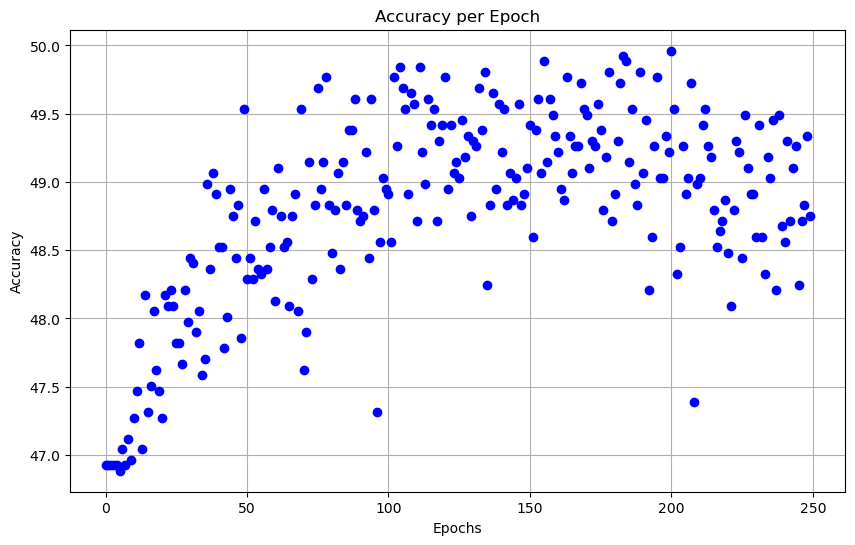

In [ ]:
import matplotlib.pyplot as plt

x = range(len(accuracy_list))
plt.figure(figsize=(10, 6))
plt.plot(x, accuracy_list, marker='o', linestyle='', color='b')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Loss Graph

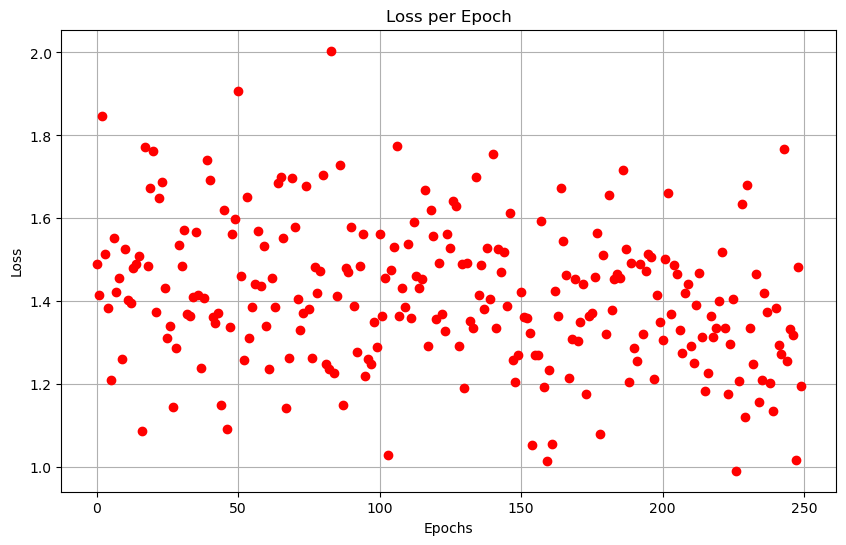

In [ ]:
x = range(len(loss_list))
plt.figure(figsize=(10, 6))
plt.plot(x, loss_list, marker='o', linestyle='', color='r')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf 
from tensorflow.keras import datasets, layers, models 
import matplotlib.pyplot as plt 

In [ ]:
X_train.shape

(10272, 300)

In [ ]:
y_train.shape

(10272,)

Just testing out another Fully Connected Layers code from a website

In [ ]:
# Initialize a sequential model
model = models.Sequential()

# Add the input layer
model.add(layers.Input(shape=(300,)))  # Adjust the input shape to match your feature vector size

# Add fully connected (Dense) layers
model.add(layers.Dense(256, activation='relu'))  # First hidden layer with 256 units
model.add(layers.Dense(128, activation='relu'))  # Second hidden layer with 128 units
model.add(layers.Dense(64, activation='relu'))   # Third hidden layer with 64 units

# Add the output layer
model.add(layers.Dense(10, activation='softmax'))  # Assuming a multi-class classification problem with 10 classes

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Suitable for integer-labeled data
              metrics=['accuracy'])

# Assuming X_train, y_train, X_test, y_test are already defined and properly preprocessed
history = model.fit(X_train, y_train, epochs=250, validation_data=(X_test, y_test))



Epoch 1/250
321/321 [==============================] - 1s 2ms/step - loss: 1.5906 - accuracy: 0.4617 - val_loss: 1.5409 - val_accuracy: 0.4692
Epoch 2/250
321/321 [==============================] - 0s 1ms/step - loss: 1.5515 - accuracy: 0.4629 - val_loss: 1.5363 - val_accuracy: 0.4692
Epoch 3/250
321/321 [==============================] - 0s 1ms/step - loss: 1.5376 - accuracy: 0.4629 - val_loss: 1.5270 - val_accuracy: 0.4692
Epoch 4/250
321/321 [==============================] - 0s 1ms/step - loss: 1.5261 - accuracy: 0.4618 - val_loss: 1.5077 - val_accuracy: 0.4657
Epoch 5/250
321/321 [==============================] - 0s 1ms/step - loss: 1.5133 - accuracy: 0.4618 - val_loss: 1.4965 - val_accuracy: 0.4677
Epoch 6/250
321/321 [==============================] - 0s 1ms/step - loss: 1.5093 - accuracy: 0.4613 - val_loss: 1.5203 - val_accuracy: 0.4688
Epoch 7/250
321/321 [==============================] - 0s 1ms/step - loss: 1.5058 - accuracy: 0.4646 - val_loss: 1.4881 - val_accuracy: 0.4743

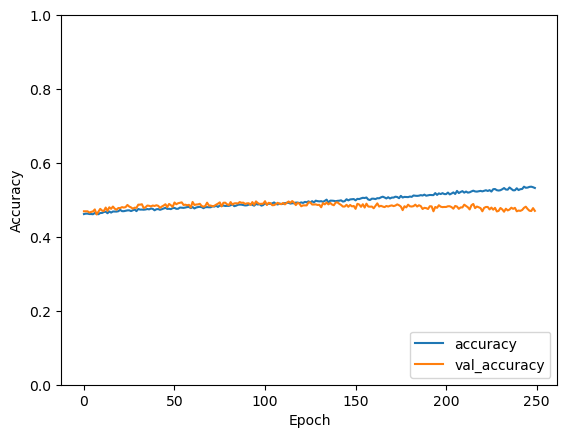

81/81 - 0s - loss: 1.5738 - accuracy: 0.4704 - 63ms/epoch - 782us/step


In [ ]:
# Plotting accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])  # Adjust the y-axis range to better fit your accuracy range
plt.legend(loc='lower right')
plt.show()

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)